In [1]:
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd
import requests
import json
from pprint import pprint
from config import gkey
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress

In [2]:
cdmx_gdp=gpd.read_file('data/shapes/09m.shp')

In [3]:
gam_gdp=cdmx_gdp[cdmx_gdp['CVE_MUN']=='005']
gam_gdp.head()

,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,TIPOMZA,geometry
13705,09,005,0001,1148,008,Típica,"POLYGON ((2802682.728 835673.649, 2802672.945 ..."
13706,09,005,0001,1152,018,Típica,"POLYGON ((2803015.393 835770.018, 2802994.766 ..."
13707,09,005,0001,1148,010,Típica,"POLYGON ((2802748.907 835754.125, 2802780.251 ..."
13708,09,005,0001,1148,007,Típica,"POLYGON ((2802668.317 835705.970, 2802677.191 ..."
13709,09,005,0001,1148,012,Típica,"POLYGON ((2802934.098 835634.631, 2802880.177 ..."


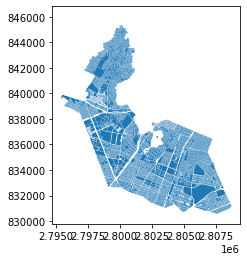

In [4]:
gam_gdp.plot()

In [18]:
gam_gps=pd.read_csv('data/GM_coords.csv')
#gam_gps = gam_gps.loc[:400]
gam_gps.head()

,Unnamed: 0,Status,m2,State,Rooms,Price,Adress,lon,lat
0,0,Casa en venta,200,construidos,3 recs.,"2,300,000","Gustavo A. Madero , Distrito Federal",-99.123613,19.487333
1,1,Casa en venta,320,construidos,3 recs.,"8,500,000","Ambato , Lindavista Norte , Gustavo A. Madero...",-99.128877,19.500071
2,2,Casa en venta,278,construidos,4 recs.,"65,500","CALLE 625 00 , San Antonio , Gustavo A. Mader...",-99.065769,19.453837
3,3,Casa en venta,160,construidos,3 recs.,"1,499,000","641 227 , San Juan De Aragón 4a Secc. , Gusta...",-99.065156,19.459747
4,4,Casa en venta,210,construidos,4 recs.,"685,000","CAIRO 303 , Fernando Casas Alemán , Gustavo A...",-99.096910,19.452036


In [19]:
geometry =[Point(xy) for xy in zip(gam_gps['lon'],gam_gps['lat'])]
crs={'init':'epsg:4326'}
points_gpd=gpd.GeoDataFrame(gam_gps,crs=crs,geometry=geometry)

In [20]:
points_gpd.head(2)

,Unnamed: 0,Status,m2,State,Rooms,Price,Adress,lon,lat,geometry
0,0,Casa en venta,200,construidos,3 recs.,"2,300,000","Gustavo A. Madero , Distrito Federal",-99.123613,19.487333,POINT (-99.12361 19.48733)
1,1,Casa en venta,320,construidos,3 recs.,"8,500,000","Ambato , Lindavista Norte , Gustavo A. Madero...",-99.128877,19.500071,POINT (-99.12888 19.50007)


In [21]:
points_gpd.crs

{'init': 'epsg:4326'}

In [22]:
# Changing CRS in GAM
gam_gdp = gam_gdp.to_crs({'init': 'epsg:4326'})
gam_gdp.crs

{'init': 'epsg:4326'}

In [23]:
points_with_gdp=sjoin(points_gpd,gam_gdp,how='left')

In [24]:
bounderies=gam_gdp.geometry.bounds

In [25]:
list(bounderies)

['minx', 'miny', 'maxx', 'maxy']

In [26]:
min_x=bounderies['minx'].min()
min_y=bounderies['miny'].min()
max_x=bounderies['maxx'].max()
max_y=bounderies['maxy'].max()

In [27]:
points_with_gdp
cl=(~points_with_gdp['CVE_ENT'].isna())

points_with_gdp=points_with_gdp[cl]

In [28]:
points_with_gdp
points_with_gdp['id']=points_with_gdp['CVE_LOC']+points_with_gdp['CVE_AGEB']+points_with_gdp['CVE_MZA']

In [29]:
points_with_gdp
cl=(points_with_gdp['lat']>max_y)|(points_with_gdp['lat']<min_y)|(points_with_gdp['lon']>max_x)|(points_with_gdp['lon']<min_x)
points_with_gdp=points_with_gdp[~cl]

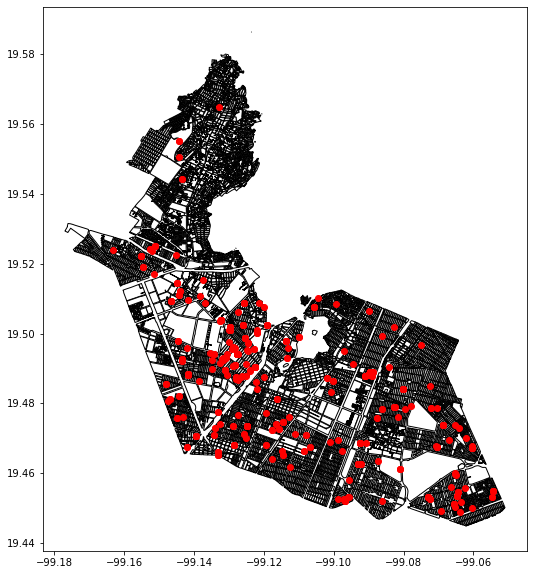

In [30]:
ax = gam_gdp.plot(figsize=(10, 10), color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
points_with_gdp.plot(ax=ax, color='red')
#plt.savefig('gam.png', transparent=True)
plt.show()

In [31]:
#df.astype({'col1': 'int32'})
#points_with_gdp
#points_with_gdp['price_m2']=points_with_gdp['price']/points_with_gdp['m2']

In [34]:
axt = gam_gdp.reset_index()
axt = axt.rename(columns={"index": "vol"})

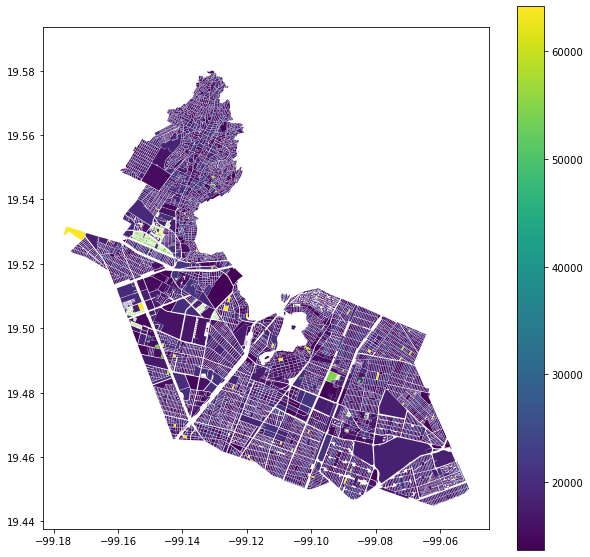

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
ax_final = axt.plot(column='vol', ax=ax, legend=True)
#plt.savefig('scale.png', transparent=True)